<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Single-agent-Markov-LLN" data-toc-modified-id="Single-agent-Markov-LLN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Single-agent Markov LLN</a></span><ul class="toc-item"><li><span><a href="#Remove-effect-of-initial-conditions" data-toc-modified-id="Remove-effect-of-initial-conditions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Remove effect of initial conditions</a></span></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualize</a></span></li></ul></li><li><span><a href="#Synthetic-panel-of-households" data-toc-modified-id="Synthetic-panel-of-households-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Synthetic panel of households</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from BewleyAiyagari import Bewley_Aiyagari as bam
from scipy.stats import skew, kurtosis
import pandas as pd

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

%matplotlib inline

# Single-agent Markov LLN

Here, we are simulating a partial equilibrium outcome for a single agent, taking price $r$ as given:

In [5]:
# AR(1) shock process to individual skill/productivity
rho = 0.8
sigma = 0.3*np.sqrt(1.-rho**2)

# Instantiate model CLASS on these parameters
wham = bam(a_lb=-2.0, a_ub=40., RHO=rho, SIGMA=sigma, NGRID_e=3)

# Fix arbitrary market relative price, note w = w(r)
r = 0.03414

**Note**: The parametrization here uses the result from a separate notebook that ran the general-equilibrium or stationary competitive equilibrium solution.

Solve dynamic program given $r$:

In [6]:
w = wham.CobbDouglas_mpl(r)
params = [r, w]
v, g = wham.Howard(params, display_howard=True)

[ =============== ] 100.00% 15/15, error1 = 0.00009    

Simulate sample path given optimal policy $(a,e) \mapsto g(a,e)$:

In [66]:
apath, epath = wham.MonteCarloSimulation(g, T_sim=100000)

## Remove effect of initial conditions

**Note**: A current agent state is $(a_{t}, e_{t})$.

To ensure we are drawing samples from the ergodic distribution of agent states, we simulate the outcomes for long enough and discard a sufficiently long "burn-in" sample:

In [67]:
T_burn = 20000

apath_burn = apath[T_burn:-1]
apath_burn.size

80000

Likewise for the Markov-chain primitive shock to earnings:

In [68]:
epath_burn = epath[T_burn::]
epath_burn.size

80000

Check that the simulation is representative of the asymptotic distribution:

In [69]:
print("Sample statistics ...\n")

S = wham.S
for idx_e, e in enumerate(S):
    print("Proportion time spent in state %i = %6.2g" 
          %(idx_e, (epath_burn[epath_burn==S[idx_e]]).size/epath_burn.size)
         )

Sample statistics ...

Proportion time spent in state 0 =   0.25
Proportion time spent in state 1 =    0.5
Proportion time spent in state 2 =   0.25


In [70]:
print("Ergodic distribution of earnings shock ...\n")

p_inf = wham.ErgodistMC(wham.P)
for idx_e, prob_e in enumerate(p_inf):
    print("Proportion time spent in state %i = %6.2f" %(idx_e, prob_e))

Ergodic distribution of earnings shock ...

Proportion time spent in state 0 =   0.25
Proportion time spent in state 1 =   0.50
Proportion time spent in state 2 =   0.25


## Visualize

Monte-Carlo sample path of agent asset position:

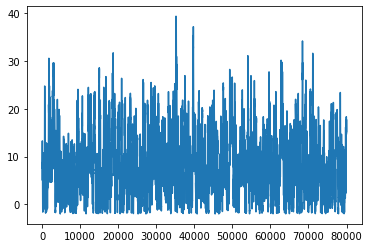

In [71]:
plt.figure()
plt.plot(apath_burn)
plt.show()

Joint distribution of asset positions:

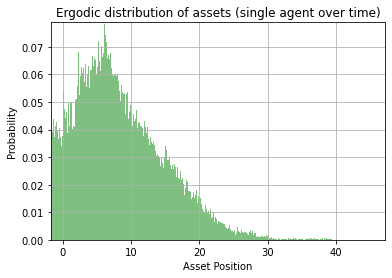

In [98]:
plt.figure()
freq, bins = wham.ShowDistro(apath_burn)
plt.show()

Check to see if there are some who end up borrowing sometimes:

In [73]:
apath_burn[apath_burn<0.0]

array([-0.05088086, -0.27567015, -0.48661618, ..., -1.06730351,
       -1.01912608, -0.43980891])

Sort by states of earnings shock outcome:

There are 20265 people in state e = 0.65
There are 39824 people in state e = 1.00
There are 19911 people in state e = 1.53


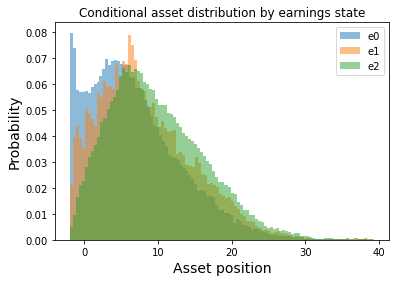

In [94]:
plt.figure()

A_sort_by_e = []

for idx_e, e in enumerate(S):
    # Conditioning on e
    apath_by_e = apath_burn[epath_burn==e]
    A_sort_by_e.append(apath_by_e)
    print("There are %i people in state e = %0.2f" 
          %(apath_by_e.size, e)
         )
    # Histograms - overlapping
    opaquefy = 0.5
    plt.hist(apath_by_e, bins=100, 
             density=True, 
             alpha=opaquefy, 
             label="e"+str(idx_e))
plt.xlabel("Asset position", size=14)
plt.ylabel("Probability", size=14)
plt.legend(loc='upper right')
plt.title("Conditional asset distribution by earnings state")
plt.show()

Let's describe the distribution of assets using a few descriptive statistics:

In [145]:
stats_single = { "Mean"     : apath_burn.mean(), 
                 "Std"      : apath_burn.std(), 
                 "Skewness" : skew(apath_burn), 
                 "Kurtosis" : kurtosis(apath_burn)
               }

In [146]:
df_single = pd.DataFrame.from_dict(stats_single, orient="index", columns=["Statistics"])
df_single

,Statistics
Mean,8.287447
Std,6.471267
Skewness,0.765374
Kurtosis,0.471935


# Synthetic panel of households

The functions below have been explicitly (and inelegantly) pulled out from our ``BewleyAiyagari.py`` class file.

We'll use this to do the panel of households simulation.

In [19]:
def SimulateMarkovChain(S, P, mu=None, T=88888):
        """Simulate T-length observations of Markov chain (mu,P)"""
        """Note: Finite state space Z admit integers or reals"""
        if mu is None:
            # Define arbitrary initial uncond. distro over Z
            mu = np.random.rand(S.size)
            mu = mu/mu.sum()
        data = np.empty(T)
        data[0] = np.random.choice(S, replace=False, p = mu)
        for t in range(T-1):
            # Find index/location of element in Z with value data[t]
            state = S.tolist().index(data[t])
            # Given state index, draw new state from conditional distro
            data[t+1] = np.random.choice(S, replace=False, p = P[state,:])         
        return data

In [20]:
def MonteCarloSimulation(g, a_init, S, P, T_sim=20000):
    a_path = [ a_init ]
    e_path = SimulateMarkovChain(S, P, T=T_sim)
    for t, e in enumerate(e_path):
        # Get index of e in S
        idx_e = S.tolist().index(e)
        # Bounds checking and updating path of a(t)
        if a_path[t] <= asset_grid_fine.min():
            # Po'-rest boy
            a_path.append(g[0, idx_e])
        elif a_path[t] >= asset_grid_fine.max():
            # Rich-est daddy-O
            a_path.append(g[-1, idx_e])
        else:
            # Typical in-betweeners
            astar = np.interp(a_path[t], asset_grid, g[:, idx_e])
            a_path.append(astar)
    return a_path

Our (earnings-shock) Markov-chain elements:

In [21]:
P = wham.P
S = wham.S

Let's simulate a panel of with time-series length ``T_panel`` and ``N_agents`` number of people initially uniformly distributed in the asset space:

In [81]:
def SimPanel(g, asset_grid_fine, S, P, N_agents, T_panel):
    A_panel = []
    for i in range(N_agents):
        A_panel.append(MonteCarloSimulation(g, asset_grid_fine[i], S, P, T_sim=T_panel))
    return A_panel

In [80]:
N_agents = 1000
T_panel = 1000
asset_grid = wham.asset_grid
asset_grid_fine = np.linspace(wham.a_lb, wham.a_ub, N_agents)

Get a sample realization of panel data of dimensions ``N_agents`` by ``T_panel``:

In [82]:
AA = SimPanel(g, asset_grid_fine, S, P, N_agents, T_panel)

In [123]:
asset_panel = np.array(AA)

Below, we want to just look at the cross-sectional distribution of the panel's final period (or wave, in panel-data lingo):

In [129]:
T_burn_panel = T_panel
asset_panel_burn = (asset_panel[:,T_burn_panel::]).flatten()

Let's describe the final-period distribution of assets using a few descriptive statistics:

In [147]:
stats_panel_xsection = { "Mean"     : asset_panel_burn.mean(), 
                         "Std"      : asset_panel_burn.std(), 
                         "Skewness" : skew(asset_panel_burn), 
                         "Kurtosis" : kurtosis(asset_panel_burn)
                       }

In [148]:
df_pxsection = pd.DataFrame.from_dict(stats_panel_xsection, orient="index", columns=["Cross section"])
df_pxsection

,Cross section
Mean,8.695082
Std,6.864774
Skewness,0.749560
Kurtosis,0.438111


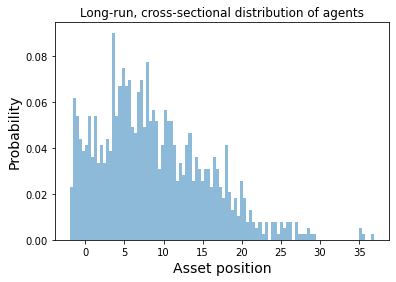

In [149]:
plt.figure()
plt.hist(asset_panel_burn, bins=100, 
             density=True, 
             alpha=0.5, 
        )
plt.xlabel("Asset position", size=14)
plt.ylabel("Probability", size=14)
plt.title("Long-run, cross-sectional distribution of agents")
plt.show()

# Summary

So the "long-run", cross-sectional empirical distribution of households is quite accurately described by the ergodic distribution assets held by the one agent over time. This is a result of the stationary equilibrium map itself possessing properties of a law of large numbers for Markov processes.

In [150]:
df_summary = pd.concat([df_single, df_pxsection], axis=1)
df_summary

,Statistics,Cross section
Mean,8.287447,8.695082
Std,6.471267,6.864774
Skewness,0.765374,0.749560
Kurtosis,0.471935,0.438111
